## 🧪 Exercise 1: Link Prediction in a Social Network using Node Embeddings

### 🔍 Objective:
Use **unsupervised graph embeddings** to predict missing links in a social network graph. This exercise combines the ideas of embedding learning (e.g., via Node2Vec) and similarity-based link prediction.

---

### 📘 Dataset:
Use a small social network such as the **Zachary's Karate Club** graph or a subgraph of the **Facebook ego-network** from SNAP.

---

### 🧭 Instructions:

1. **Graph Preparation**:
   - Load a graph using NetworkX (e.g., `karate_club_graph()`).
   - Randomly remove a percentage of existing edges (e.g., 10%) to simulate missing links.
   - Keep the rest as your **training graph**.

2. **Embedding Learning**:
   - Apply **Node2Vec** or another random-walk-based method (like DeepWalk) to learn node embeddings on the training graph.
   - Use the `node2vec` Python package or implement the random walks manually.

3. **Link Prediction**:
   - Define a similarity function (e.g., **dot product** or **cosine similarity**) between node embeddings.
   - For each missing edge and a set of randomly generated non-existing edges (**negative samples**), compute similarity scores.
   - Predict edges based on these scores.

4. **Evaluation**:
   - Report the quality of link prediction using **AUC score** or **Precision@K**.

5. *(Optional)* **Visualization**:
   - Reduce embedding dimensions to 2D using PCA or t-SNE.
   - Visualize node embeddings to interpret the learned space.

---

### 📦 Suggested Libraries:
```python
networkx, node2vec, numpy, scikit-learn, matplotlib, torch (optional)


Original graph has 34 nodes and 78 edges


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.49it/s]


AUC Score for Link Prediction using Node2Vec: 0.7143


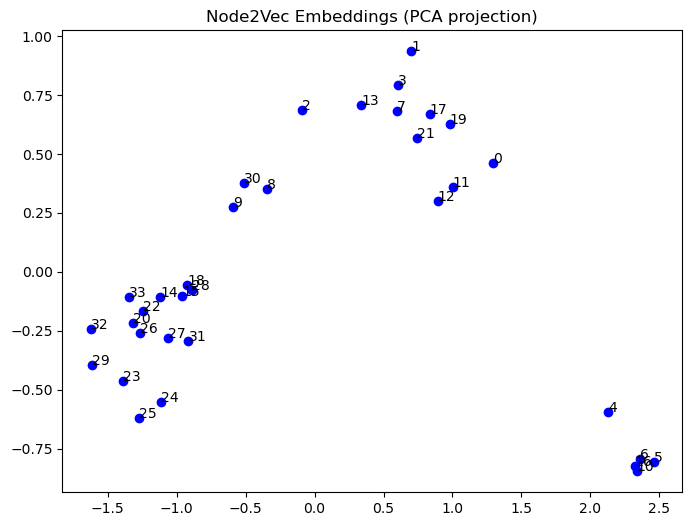

In [1]:
# Link Prediction using Node2Vec and Graph Autoencoder
# ------------------------------------------------------
# Goal: Predict missing edges in a social network graph using unsupervised embeddings

import networkx as nx
import numpy as np
import random
import torch
from sklearn.metrics import roc_auc_score
from node2vec import Node2Vec
import matplotlib.pyplot as plt

# Step 1: Load a graph (e.g., ego-Facebook or Karate Club)
G = nx.karate_club_graph()
print(f"Original graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Step 2: Create train/test split by removing some edges
edges = list(G.edges())
random.seed(42)
random.shuffle(edges)
num_test = int(0.1 * len(edges))
test_edges = edges[:num_test]
train_edges = edges[num_test:]

# Create a new train graph
G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(train_edges)

# Step 3: Learn node embeddings using Node2Vec
node2vec = Node2Vec(G_train, dimensions=64, walk_length=10, num_walks=100, workers=1)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Step 4: Define a similarity function (e.g., dot product)
def edge_similarity(u, v):
    if str(u) in model.wv and str(v) in model.wv:
        return np.dot(model.wv[str(u)], model.wv[str(v)])
    return 0

# Step 5: Generate negative edges (non-existing edges)
def generate_negative_edges(G, num_samples):
    nodes = list(G.nodes())
    negatives = set()
    while len(negatives) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negatives.add((u, v))
    return list(negatives)

negative_edges = generate_negative_edges(G_train, len(test_edges))

# Step 6: Evaluate
true_edges = test_edges
false_edges = negative_edges

y_true = [1] * len(true_edges) + [0] * len(false_edges)
y_score = [edge_similarity(u, v) for (u, v) in true_edges + false_edges]

auc_score = roc_auc_score(y_true, y_score)
print(f"AUC Score for Link Prediction using Node2Vec: {auc_score:.4f}")

# Optional: Visualize embedding (projected to 2D)
from sklearn.decomposition import PCA
embeds = np.array([model.wv[str(i)] for i in G_train.nodes()])
pca = PCA(n_components=2)
embeds_2d = pca.fit_transform(embeds)
plt.figure(figsize=(8,6))
plt.scatter(embeds_2d[:,0], embeds_2d[:,1], c='blue')
for i, txt in enumerate(G_train.nodes()):
    plt.annotate(txt, (embeds_2d[i,0], embeds_2d[i,1]))
plt.title("Node2Vec Embeddings (PCA projection)")
plt.show()
